In [72]:

import pandas as pd
import numpy as np
import pandas_datareader as web
from matplotlib import pyplot as plt
%matplotlib inline
import yfinance as yfin
yfin.pdr_override()
import pypfopt
#plt.style.use('fivethirtyeight') 

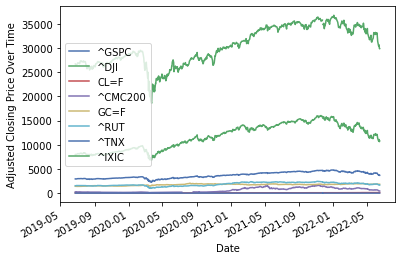

In [73]:
symbols = [
'^GSPC',#SPY500
'^DJI',
'CL=F',
#'BTC-CAD',
'^CMC200',
'GC=F',
'^RUT',
'^TNX',
'^IXIC',
#'^N225'
]

from datetime import datetime, timedelta
start =  datetime.today() - timedelta(weeks=52*3) #Last 3 years
end = datetime.today()
#print(start, end)

#stock_data = yfin.download(symbols, range = '1yr', group_by= 'ticker', auto_adjust=True, prepost=True, reads=True, proxy=None)
stock_data = web.get_data_yahoo(symbols, start, end)
#print(stock_data.head())
stock_data["Adj Close"].plot(ylabel="Adjusted Closing Price Over Time")
plt.legend(loc = 'center left')

#print(stock_data["Adj Close"].head())
#stock_data_daily_pct_log = stock_data["Adj Close"].pct_change().apply(lambda x: np.log(1+x))
#stock_data_daily_pct_log.plot(ylabel="Log Daily Return", alpha=0.5)
#print(stock_data_daily_pct_log)

<AxesSubplot:>

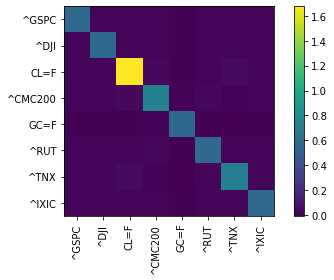

In [74]:
#mean historical price and covariance

from pypfopt.expected_returns import mean_historical_return
from pypfopt.expected_returns import capm_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import plotting
import seaborn as sns

historical_prices = stock_data["Adj Close"].dropna()
mu = mean_historical_return(historical_prices)
#mu = capm_return(historical_prices)
cov = CovarianceShrinkage(historical_prices).ledoit_wolf()
#print(cov)
#sns.heatmap(cov)
pypfopt.plotting.plot_covariance(cov)

In [75]:
def plot_frontier(efficient_frontier):
    #plot frontier
    fig, ax = plt.subplots()
    #plotting.plot_efficient_frontier(efficient_frontier, ax=ax, show_assets = False)
    #tangency portfolio

    ret_tangent, std_tangent, _ = efficient_frontier.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker = '*', s=100, c='r', label = "Max Sharpe")

    #random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(efficient_frontier.n_assets), n_samples)
    rets = w.dot(efficient_frontier.expected_returns)
    stds = np.sqrt(np.diag(w @ efficient_frontier.cov_matrix @ w.T))
    sharpes = rets/stds
    ax.scatter(stds, rets, marker = '.', c=sharpes, cmap = 'viridis_r')

    #output
    ax.set_title("EfficientFrontier")
    ax.legend()
    plt.tight_layout()
    plt.show()

{'^GSPC': 0.08974, '^DJI': 0.01031, 'CL=F': 0.13425, '^CMC200': 0.26636, 'GC=F': 0.14311, '^RUT': -0.01568, '^TNX': 0.22496, '^IXIC': 0.14694}
Expected annual return: 16.9%
Annual volatility: 39.9%
Sharpe Ratio: 0.37


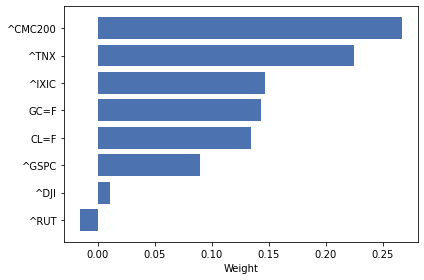

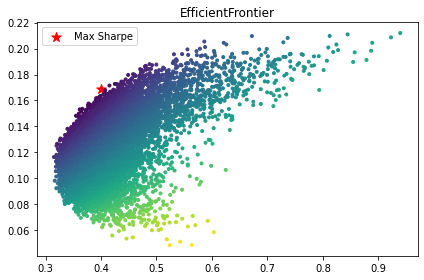

In [76]:
#mean variance optimization

from pypfopt.efficient_frontier import EfficientFrontier

efficient_frontier = EfficientFrontier(mu, cov, weight_bounds = (-1,1))
weights = efficient_frontier.max_sharpe()
cleaned_weights = dict(efficient_frontier.clean_weights())
print(cleaned_weights)
efficient_frontier.portfolio_performance(verbose = True)

plotting.plot_weights(cleaned_weights)
plot_frontier(efficient_frontier)


C:\Users\Ben\AppData\Roaming\Python\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


{'^GSPC': 0.0881, '^DJI': 0.01257, 'CL=F': 0.14393, '^CMC200': 0.26496, 'GC=F': 0.13651, '^RUT': -0.01137, '^TNX': 0.22269, '^IXIC': 0.14262}
{'^GSPC': 24, 'CL=F': 1300, '^CMC200': 598, 'GC=F': 74, '^TNX': 68008, '^IXIC': 14, '^RUT': -6}
Expected annual return: 17.0%
Annual volatility: 40.1%
Sharpe Ratio: 0.37


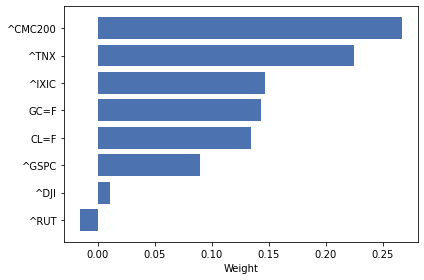

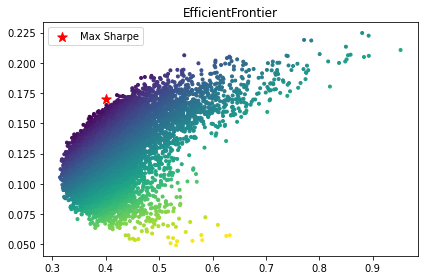

In [77]:
#L2 regularisation

from pypfopt import objective_functions

efficient_frontier = EfficientFrontier(mu, cov, weight_bounds = (-1,1))
efficient_frontier.add_objective(objective_functions.L2_reg, gamma=0.1)
w = efficient_frontier.max_sharpe()
print(dict(efficient_frontier.clean_weights()))

#Post processing

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(historical_prices)
discrete_allocation = DiscreteAllocation(w, latest_prices, total_portfolio_value= 1000000)
allocation, leftover = discrete_allocation.lp_portfolio()
print(allocation)
efficient_frontier.portfolio_performance(verbose = True)

plotting.plot_weights(cleaned_weights)
plot_frontier(efficient_frontier)


{'CL=F': 0.004668345703529099, 'GC=F': 0.63561410408252, '^CMC200': 0.026753583200967136, '^DJI': 0.08610731238075518, '^GSPC': 0.08754403880879287, '^IXIC': 0.07255498401871155, '^RUT': 0.056383996399498454, '^TNX': 0.03037363540522566}
Expected annual return: 12.4%
Annual volatility: 15.9%
Sharpe Ratio: 0.65


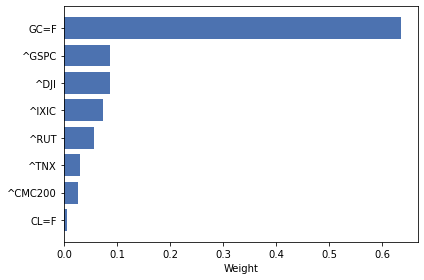

<AxesSubplot:>

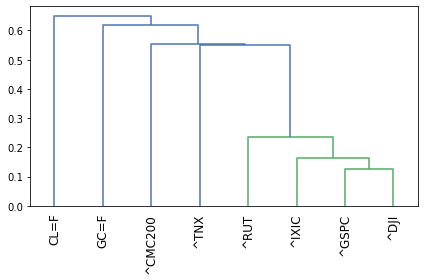

In [78]:
#Heirarchical Risk Parity

from pypfopt import HRPOpt

returns = historical_prices.pct_change()
hrp = HRPOpt(returns)
hrp_weights = hrp.optimize()
print(dict(hrp_weights))
hrp.portfolio_performance(verbose=True)

plotting.plot_weights(hrp_weights)
plt.show()
plotting.plot_dendrogram(hrp)

